## Loads

In [1]:
import sys
import os
script_dir = os.getcwd()
root_dir = os.path.join(os.path.dirname(os.path.abspath(script_dir)))
sys.path.append(os.path.join(os.path.dirname(os.path.abspath(script_dir))))
os.chdir(root_dir)

In [2]:
os.getcwd()

'/home/helenajun/rag-llm-cancer-paper'

In [3]:
# !pip install rank_bm25
import json
import pandas as pd
import numpy as np
from utils.io import load_object, save_object
import requests
import random
import math
from transformers import AutoTokenizer, AutoModelForTokenClassification
from context_retriever.entity_prediction import extract_entities, db_extract_entities
import ast
from utils.check_db_version import get_local_version
from utils.evaluation import calc_eval_metrics
from utils.embedding import prep_embed_for_search, get_text_embedding, retrieve_context
from context_retriever.hybrid_search import retrieve_context_hybrid
from dotenv import load_dotenv
from openai import OpenAI
import faiss
from rapidfuzz import fuzz
from rank_bm25 import BM25Okapi
from dataclasses import dataclass
from typing import List, Dict, Any


In [4]:
#split ranges for testing on small batches
def split_ranges(max_int, num_ranges, samples=None, seed=42):
    random.seed(seed)
    step = math.ceil(max_int / num_ranges)
    ranges = [(i*step+1, min((i+1)*step, max_int)) for i in range(num_ranges)]
    
    if samples is None:
        return ranges
    
    # split samples evenly across ranges
    n_per_range = samples // num_ranges
    remainder = samples % num_ranges
    
    result = []
    for i, r in enumerate(ranges):
        count = n_per_range + (1 if i < remainder else 0)
        result.extend(random.randint(r[0], r[1]) for _ in range(count))
    
    return result

#get ground-truth drug entry from db for evaluation
def get_true_drug_db(moalmanac_db, db_idx):
    subset = moalmanac_db[
        (moalmanac_db["modified_standardized_cancer"] == moalmanac_db["modified_standardized_cancer"].iloc[db_idx]) &
        (moalmanac_db["biomarker"] == moalmanac_db["biomarker"].iloc[db_idx])
    ]
    return subset

_VERSION=get_local_version()
_VERSION

'2025-09-04'

## Test hybrid search for RAG

BM25 (sparse retrieval): 
- works well when exact terms in query match documents, so it's good for keyword-heavy queries
- considers document length, so longer documents don't get unfairly higher scores because they contain more words, which is the problem in naive entity matching 
- one limitation is that the score will highly depend on the entity extraction quality

Fuzzy matching:
- to handle fuzzy matches between NER entities

FAISS cosine similarity (dense retrieval): 
- captures semantic similarity (even if exact words don't match) 

Hybrid approach:
1. Use BM25 to retrieve a short list of relevant documents
2. Retrieve top-k based on vector similarity using FAISS
3. Re-rank with a cross-encoder

In [ ]:
#test hybrid matching
from typing import List, Dict
import faiss
from utils.embedding import get_text_embedding, prep_embed_for_search, retrieve_context
from context_retriever.hybrid_search import retrieve_context_hybrid
from dotenv import load_dotenv
from openai import OpenAI
from rank_bm25 import BM25Okapi


def check_list(input) -> List[str]:
    if isinstance(input, list):
        input = input
    else:
        input = [input]
    return input


def tokenize_single_entity(entity: str) -> List[str]:
    tokens = entity.split()
    return tokens


def tokenize_corpus(
    corpus: list[dict[str, list[str]]], 
    entity=['cancer_type', 'biomarker']
    ) -> Dict[List[str], List[str]]:
    tokenized_corpus = []
    for doc in corpus:
        tokenized_doc = {}
        for ent in entity:
            tokenized_ent = []
            for e in doc[ent]:
                if e is not None and isinstance(e, str):
                    tokenized_ent.extend(tokenize_single_entity(e))
                    
            tokenized_doc[ent] = tokenized_ent
            
        tokenized_corpus.append(tokenized_doc)
    
    return tokenized_corpus


def min_max_scaling(score: np.ndarray, eps=1e-8) -> np.ndarray:
    norm_score=(score - score.min())/(score.max()-score.min()+eps)
    return norm_score
    

load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
_CLIENT = OpenAI(api_key=api_key)
_MODEL_EMBED = "text-embedding-3-small"
_INDEX=faiss.read_index(f"./data/latest_db/indexes/text-embedding-3-small_structured_context__{_VERSION}.faiss")
with open(f"context_retriever/entities/moalmanac_db_ner_entities__{_VERSION}.json", "r") as f:
    _DB_ENTITY = json.load(f)
with open(f"context_retriever/entities/synthetic_query_ner_entities__{_VERSION}.json", "r") as f:
    _QUERY_ENTITY = json.load(f)
with open(f"data/latest_db/indexes/text-embedding-3-small_structured_context__{_VERSION}.json", "r") as f:
    _CONTEXT = json.load(f)
moalmanac_db = pd.read_csv(f"data/latest_db/moalmanac_core__{_VERSION}.csv")
with open(f"data/latest_db/synthetic_prompts__{_VERSION}.json", "r") as f:
    synthetic_query=json.load(f)
synthetic_query_therapy_pair_dict=load_object("data/latest_db/synthetic_query_therapy_pair_dict.pkl")
small_val_idx = split_ranges(len(_CONTEXT), 10, 20)
print(small_val_idx)

[15, 4, 101, 97, 159, 148, 209, 207, 315, 265, 329, 337, 418, 420, 520, 459, 546, 574, 600, 614]


In [ ]:
from dataclasses import dataclass
from typing import List, Dict, Any

@dataclass
class HybridRetrievalResult:
    top_contexts: List[str] # final list of top re-ranked contexts
    retrieved_df: pd.DataFrame  # detailed DataFrame with all scores
    params: Dict[str, Any]


def retrieve_context_hybrid(
    user_entities: dict[str, list[str]], 
    db_entities: list[dict[str, list[str]]],
    user_query: str,
    db_context,
    index,
    client,
    model_embed,
    bm25_top_k=25,
    w_c=0.3,
    w_b=0.3,
    w_ctx=0.4,
    num_vec=10
    ) -> HybridRetrievalResult:
    """
    Performs hybrid search and retrieval with two stages:
    1. Sparse retrieval (BM25):
        - Uses keyword-based scoring on tokenized entities (`cancer_type` and `biomarker`)
        - Combines entity-level BM25 scores with pre-defined weights
        - Selects top-k candidate contexts
    2. Dense re-ranking (FAISS):
        - Computes query embeddings with the given model
        - Retrieves semantically similar context using FAISS cosine similarity
        - Aligns FAISS scores with BM25-selected contexts and re-ranks
    
    Returns:
        - A list of top `num_vec` re-ranked contexts
        - A DataFrame containing context, BM25 scores, FAISS similarity, and final rankings score
    
    Notes:
        - BM25 captures lexical (exact keyword match) signals
        - FAISS cosine similarity captures semantic similarity, ensuring better ranking of relevant contexts with synonyms
        - Final ranking score is a product of BM25 score and cosine similarity for balanced ranking
    """
    
    #extract user cancer/biomarker entities (handles none)
    user_cancer = check_list(user_entities.get('cancer_type', []))
    user_biomarker = check_list(user_entities.get('biomarker', []))
    
    #tokenize user query and corpus
    tokenized_user_query=tokenize_single_entity(user_query)
    tokenized_db_context=[tokenize_single_entity(ctx) for ctx in db_context]
    
    #tokenize user and db entities (cancer/biomarker) for fine-grained matching
    tokenized_db_entities=tokenize_corpus(db_entities)
    tokenized_user_cancer = [token for e in user_cancer if e for token in tokenize_single_entity(e)]
    tokenized_user_biomarker = [token for e in user_biomarker if e for token in tokenize_single_entity(e)]
    
    #build BM25 indices for each type of information
    cancer_bm25=BM25Okapi([doc['cancer_type'] for doc in tokenized_db_entities])
    biomarker_bm25=BM25Okapi([doc['biomarker'] for doc in tokenized_db_entities])
    context_bm25=BM25Okapi(tokenized_db_context)
    
    #bm25 scoring for user entities (captures lexical match; one caveat is that it relies on NER quality)
    if tokenized_user_cancer:
        cancer_bm25_score=cancer_bm25.get_scores(tokenized_user_cancer)
        #normalized to [0,1]
        cancer_bm25_score_norm=min_max_scaling(cancer_bm25_score)
        #zero score vector if no entity detected 
    else: cancer_bm25_score_norm=np.zeros(len(db_context)) 
    if tokenized_user_biomarker:
        biomarker_bm25_score=biomarker_bm25.get_scores(tokenized_user_biomarker)
        biomarker_bm25_score_norm=min_max_scaling(biomarker_bm25_score)
    else: biomarker_bm25_score_norm=np.zeros(len(db_context))
    
    #bm25 scoring for free-text contexts (captures info missed by entity extraction like disease modifiers)
    context_bm25_score=context_bm25.get_scores(tokenized_user_query)
    context_bm25_score_norm=min_max_scaling(context_bm25_score)    
    
    #combine bm25 scores (weighted sum of the three normalized BM25 scores with weight highest for context)
    combined_score = w_c * cancer_bm25_score_norm + w_b * biomarker_bm25_score_norm + w_ctx * context_bm25_score_norm
    
    #fall back entirely on FAISS semantic similarity when there is low BM25 combined score
    if np.max(combined_score) < 0.1:
        retrieved_chunks, D, I = retrieve_context(
            db_context, 
            user_query,
            client,
            model_embed,
            index,
            num_vec
            )
        faiss_cosine_sim_norm_ordered=(D.ravel()+1)/2
        
        #return only semantic search results
        retrieved_combined=pd.DataFrame({
            'bm25_retrieved_context':None,
            'bm25_index':None,
            'bm25_combined_score':None,
            'faiss_retrieved_context':retrieved_chunks,
            'faiss_cosine_sim':faiss_cosine_sim_norm_ordered
            })
        
    else:
        #top BM25 results
        bm25_top_idx = np.argsort(combined_score)[-bm25_top_k:][::-1]
        bm25_top_scores = combined_score[bm25_top_idx]
        bm25_top_context = [db_context[i] for i in bm25_top_idx]
        
        #FAISS re-ranking on BM25 candidates (captures semantic similarity)
        factor = max(2, min(10, index.ntotal // bm25_top_k)) #determines num. of FAISS neighbors to retrieve
        query_embeddings=np.array([get_text_embedding(user_query, client, model_embed)])
        query_embeddings_norm = query_embeddings/np.linalg.norm(query_embeddings, axis=1, keepdims=True)
        D, I = index.search(prep_embed_for_search(query_embeddings_norm, n_dim=2), k=bm25_top_k*factor)
        faiss_cosine_sim=(D.ravel()+1)/2
        faiss_indices=I.ravel()
        faiss_sim_lookup=dict(zip(faiss_indices, faiss_cosine_sim))
        faiss_cosine_sim_norm_ordered=[faiss_sim_lookup.get(idx, 0) for idx in bm25_top_idx]
        
        #combine BM25+FAISS for final reranking
        retrieved_combined=pd.DataFrame({
            'bm25_retrieved_context':bm25_top_context,
            'bm25_index':bm25_top_idx,
            'bm25_combined_score':bm25_top_scores,
            'faiss_retrieved_context':None,
            'faiss_cosine_sim':faiss_cosine_sim_norm_ordered
            })
        #hybrid score
        retrieved_combined['final_ranking_score']=retrieved_combined['faiss_cosine_sim']*retrieved_combined['bm25_combined_score']
        retrieved_combined=retrieved_combined.sort_values('final_ranking_score', ascending=False)
        
        #top-n final context chunks
        retrieved_chunks=retrieved_combined['bm25_retrieved_context'].head(num_vec).tolist()
        
    params = {
        'bm25_top_k':bm25_top_k,
        'w_c':w_c,
        'w_b':w_b,
        'w_ctx':w_ctx,
        'factor':factor,
        'num_vec':num_vec
    }
    
    return HybridRetrievalResult(
        top_contexts=retrieved_chunks, 
        retrieved_df=retrieved_combined,
        params=params            
    )


Sparse and dense search retrieval steps:
1. Cancer type, biomarker, context search using BM20 scoring:
    - combining BM20 scores from each search with weights: cancer type, biomarker, and context

2. Dense semantic similarity search using FAISS cosine similarity
3. Combine 1 and 2 scores for final re-ranking. If no entities are found in 1., then lean to semantic search 2. only

## Quick evaluation

In [8]:
moalmanac_db_query=pd.concat([moalmanac_db, pd.Series(synthetic_query)],axis=1)
moalmanac_db_query=moalmanac_db_query.rename(columns={0:'prompt'})
for entry in moalmanac_db_query.loc[small_val_idx].itertuples():
    print(entry.Index)
    print(entry.prompt)
    print(_QUERY_ENTITY[entry.Index])

15
if a patient with metastatic castration-resistant prostate adenocarcinoma cancer has bard1 oncogenic variants, what therapy is recommended?
{'cancer_type': ['prostate adenocarcinoma cancer'], 'biomarker': ['bard1']}
4
if a patient with advanced or metastatic invasive breast carcinoma cancer has pr positive, her2-negative, what therapy is recommended?
{'cancer_type': ['invasive breast carcinoma cancer'], 'biomarker': ['her2', 'pr']}
101
if a patient with unresectable or metastatic any solid tumor cancer has braf p.v600e, what therapy is recommended?
{'cancer_type': ['solid tumor cancer'], 'biomarker': []}
97
if a patient with melanoma cancer has braf p.v600k, what therapy is recommended?
{'cancer_type': ['melanoma cancer'], 'biomarker': []}
159
if a patient with advanced or metastatic invasive breast carcinoma cancer has pr positive, her2-negative, er positive, what therapy is recommended?
{'cancer_type': ['invasive breast carcinoma cancer'], 'biomarker': ['er', 'her2', 'pr']}
148
if

### Test which alpha to use for final combined score: alpha*bm25_combined_score + (1-alpha)*faiss_cosine_sim

In [ ]:
moalmanac_db_query=pd.read_csv(f'data/latest_db/moalmanac_core_query__{_VERSION}.csv', index_col=0)


0      if a patient with early invasive breast carcin...
1      if a patient with early invasive breast carcin...
2      if a patient with early invasive breast carcin...
3      if a patient with advanced or metastatic invas...
4      if a patient with advanced or metastatic invas...
                             ...                        
637    if a patient with invasive breast carcinoma ca...
638    if a patient with non-small cell lung cancer c...
639    if a patient with invasive breast carcinoma ca...
640    if a patient with non-small cell lung cancer c...
641    if a patient with lung non-squamous non-small ...
Name: prompt, Length: 642, dtype: object

In [122]:
#function to calculate recall at top_k retrieved context
def recall_at_k(db, predicted_chunks, ground_truth_drugs, k=10):
    """
    db: db with query `prompt` and `context` columns
    predicted_chunks: list of retrieved contexts
    ground_truth_drugs: set of drug names considered correct for this query
    k: top-k cutoff
    """
    retrieved_drugs = [drug for c in predicted_chunks for drug in db[db['context']==c].therapy.apply(ast.literal_eval)]
    retrieved_drugs = [{d.lower() for d in d_set} for d_set in retrieved_drugs]

    ground_truth_drugs = frozenset(frozenset(d_true) for d_true in ground_truth_drugs)
    retrieved_drugs_unique = frozenset(frozenset(d_set) for d_set in retrieved_drugs if d_set in ground_truth_drugs)

    if ground_truth_drugs:
        acc = len(retrieved_drugs_unique & ground_truth_drugs)/len(ground_truth_drugs)
    else:
       acc = None
    
    return acc

Test on small batch of samples

In [34]:
val_idx=small_val_idx
val_queries=np.array(synthetic_query)[val_idx]
alphas = np.linspace(0, 1, 6)
k = 10

best_alpha = None
best_recall = -1

for alpha in alphas:
    recalls = []
    for idx, q in zip(val_idx, np.array(synthetic_query)[val_idx]):
        #get candidate context indices and their BM25 and FAISS scores
        retrieved_res = retrieve_context_hybrid(
            user_entities=_QUERY_ENTITY[idx], 
            db_entities=_DB_ENTITY,
            user_query=q,
            db_context=_CONTEXT,
            index=_INDEX,
            client=_CLIENT,
            model_embed=_MODEL_EMBED
        )
        
        #retrieved context sorted by bm25 scores
        retrieved_res = retrieved_res.retrieved_df.sort_values('bm25_combined_score', ascending=False)
        candidates = retrieved_res.bm25_index
        bm25_scores = retrieved_res.bm25_combined_score
        faiss_scores = retrieved_res.faiss_cosine_sim
        
        #final score
        final_score = alpha*bm25_scores + (1-alpha)*faiss_scores
        
        #rank candidates based on final score
        ranked_candidates = [c for _, c in sorted(zip(final_score, candidates), reverse=True)]
        
        # compute recall@k
        r = recall_at_k(moalmanac_db, ranked_candidates, synthetic_query_therapy_pair_dict[q], k=k)
        recalls.append(r)
    
    mean_recall = np.mean(recalls)
    print(f"alpha={alpha:.1f} -> mean recall@{k}={mean_recall:.3f}")
    
    if mean_recall > best_recall:
        best_recall = mean_recall
        best_alpha = alpha

print(f"Best alpha: {best_alpha}, recall@{k}={best_recall:.3f}")


alpha=0.0 -> mean recall@10=0.912
alpha=0.2 -> mean recall@10=0.972
alpha=0.4 -> mean recall@10=0.962
alpha=0.6 -> mean recall@10=0.932
alpha=0.8 -> mean recall@10=0.921
alpha=1.0 -> mean recall@10=0.921
Best alpha: 0.2, recall@10=0.972


Test on a larger batch of samples

In [36]:
#balanced sampling of validation set for grid search
from sklearn.model_selection import train_test_split

val_df = moalmanac_db.groupby('modified_standardized_cancer').apply(
    lambda x: x.sample(min(len(x), 3), random_state=42)
)

val_idx=np.array(moalmanac_db[moalmanac_db['statement_id'].isin(val_df.statement_id)].index)
print(len(val_idx))

237


In [37]:
val_queries=np.array(synthetic_query)[val_idx]
alphas = np.linspace(0, 1, 6)
k = 10

best_alpha = None
best_recall = -1

for alpha in alphas:
    recalls = []
    for idx, q in zip(val_idx, np.array(synthetic_query)[val_idx]):
        #get candidate context indices and their BM25 and FAISS scores
        retrieved_res = retrieve_context_hybrid(
            user_entities=_QUERY_ENTITY[idx], 
            db_entities=_DB_ENTITY,
            user_query=q,
            db_context=_CONTEXT,
            index=_INDEX,
            client=_CLIENT,
            model_embed=_MODEL_EMBED
        )
        
        #sort by bm25 scores
        retrieved_res = retrieved_res.retrieved_df.sort_values('bm25_combined_score', ascending=False)
        candidates = retrieved_res.bm25_index
        bm25_scores = retrieved_res.bm25_combined_score
        faiss_scores = retrieved_res.faiss_cosine_sim
        
        #final score
        final_score = alpha*bm25_scores + (1-alpha)*faiss_scores
        
        #rank candidates based on final score
        ranked_candidates = [c for _, c in sorted(zip(final_score, candidates), reverse=True)]
        
        # compute recall@k
        r = recall_at_k(moalmanac_db, ranked_candidates, synthetic_query_therapy_pair_dict[q], k=k)
        recalls.append(r)
    
    mean_recall = np.mean(recalls)
    print(f"alpha={alpha:.1f} -> mean recall@{k}={mean_recall:.3f}")
    
    if mean_recall > best_recall:
        best_recall = mean_recall
        best_alpha = alpha

print(f"Best alpha: {best_alpha}, recall@{k}={best_recall:.3f}")


alpha=0.0 -> mean recall@10=0.930
alpha=0.2 -> mean recall@10=0.991
alpha=0.4 -> mean recall@10=0.990
alpha=0.6 -> mean recall@10=0.988
alpha=0.8 -> mean recall@10=0.989
alpha=1.0 -> mean recall@10=0.989
Best alpha: 0.2, recall@10=0.991


### Inspect which queries benefit the most from alpha tuning

In [78]:
alpha_0 = 0 #pure faiss
alpha_best = 0.2 
val_idx=small_val_idx

retrieved_res_ls=[]
recall_0=[]
recall_best=[]
r_diff=[]
for idx, q in zip(val_idx, np.array(synthetic_query)[val_idx]):
    retrieved_res = retrieve_context_hybrid(
            user_entities=_QUERY_ENTITY[idx], 
            db_entities=_DB_ENTITY,
            user_query=q,
            db_context=_CONTEXT,
            index=_INDEX,
            client=_CLIENT,
            model_embed=_MODEL_EMBED
        )
    retrieved_res = retrieved_res.retrieved_df.sort_values('bm25_combined_score', ascending=False)
    candidates = retrieved_res.bm25_index
    bm25_scores = retrieved_res.bm25_combined_score
    faiss_scores = retrieved_res.faiss_cosine_sim
    retrieved_res_ls.append(retrieved_res)
    
    hybrid_0 = alpha_0*bm25_scores + (1-alpha_0)*faiss_scores
    hybrid_best = alpha_best*bm25_scores + (1-alpha_best)*faiss_scores
    
    ranked_candidates_0 = [c for _, c in sorted(zip(hybrid_0, candidates), reverse=True)]
    ranked_candidates_best = [c for _, c in sorted(zip(hybrid_best, candidates), reverse=True)]
    
    r_0 = recall_at_k(moalmanac_db, ranked_candidates_0, synthetic_query_therapy_pair_dict[q], k=k)
    r_best = recall_at_k(moalmanac_db, ranked_candidates_best, synthetic_query_therapy_pair_dict[q], k=k)
    recall_0.append(r_0)
    recall_best.append(r_best)
    r_diff.append((r_best-r_0)/r_0)

In [90]:
df_gain = pd.DataFrame({
    'query_idx': small_val_idx,
    'query': np.array(synthetic_query)[small_val_idx],
    'recall_alpha_0': recall_0,
    'recall_alpha_best': recall_best,
    'recall_gain': r_diff
    })

df_gain.sort_values("recall_gain", ascending=False)

,query_idx,query,recall_alpha_0,recall_alpha_best,recall_gain
7,207,if a patient with acute myeloid leukemia cance...,0.500000,1.000000,1.000000
5,148,if a patient with invasive breast carcinoma ca...,0.666667,1.000000,0.500000
19,614,if a patient with early invasive breast carcin...,0.833333,1.000000,0.200000
13,420,if a patient with early invasive breast carcin...,0.900000,1.000000,0.111111
12,418,if a patient with early invasive breast carcin...,0.900000,1.000000,0.111111
11,337,if a patient with metastatic castration-resist...,1.000000,1.000000,0.000000
18,600,if a patient with pancreatic adenocarcinoma ca...,1.000000,1.000000,0.000000
17,574,if a patient with oligodendroglioma cancer has...,1.000000,1.000000,0.000000
16,546,if a patient with high-grade serous fallopian ...,1.000000,1.000000,0.000000
15,459,if a patient with high-grade serous fallopian ...,1.000000,1.000000,0.000000


In [107]:
recall_gain_idx=df_gain.sort_values("recall_gain", ascending=False).head(5).query_idx.values
recall_gain_df_idx=df_gain.sort_values("recall_gain", ascending=False).head(5).index

In [117]:
for idx, idx_df in zip(recall_gain_idx, recall_gain_df_idx):
    print(f"#============={idx}=============#")
    print(synthetic_query[idx])
    print(_QUERY_ENTITY[idx])
    print(_CONTEXT[idx])
    print(retrieved_res_ls[idx_df].head(5))
    print(get_true_drug_db(moalmanac_db, db_idx=idx).index)
    print(synthetic_query_therapy_pair_dict[synthetic_query[idx]])

#=============207=============#
if a patient with acute myeloid leukemia cancer has idh1 p.r132l, what therapy is recommended?
{'cancer_type': ['acute myeloid leukemia cancer'], 'biomarker': ['idh1']}
If a patient with acute myeloid leukemia cancer has idh1 p.r132l, one recommended therapy is ivosidenib + azacitidine. therapy type: targeted therapy + chemotherapy. therapy strategy: idh1 inhibition + hypomethylating agent chemotherapy. indication: tibsovo is an isocitrate dehydrogenase-1 (idh1) inhibitor indicated for patients with a susceptible idh1 mutation as detected by an fda-approved test with in combination with azacitidine or as monotherapy for the treatment of newly diagnosed aml in adults 75 years or older, or who have comorbidities that preclude use of intensive induction chemotherapy. approval url: https://www.accessdata.fda.gov/drugsatfda_docs/label/2023/211192s011lbl.pdf
                              bm25_retrieved_context  bm25_index  \
0  If a patient with relapsed or re

### Final retrieval pipeline with the best alpha

In [ ]:
from dataclasses import dataclass
from typing import List, Dict, Any


def tokenize_single_entity(entity: str) -> List[str]:
    tokens = entity.split()
    return tokens


def tokenize_corpus(
    corpus: list[dict[str, list[str]]], 
    entity=['cancer_type', 'biomarker']
    ) -> Dict[List[str], List[str]]:
    tokenized_corpus = []
    for doc in corpus:
        tokenized_doc = {}
        for ent in entity:
            tokenized_ent = []
            for e in doc[ent]:
                if e is not None and isinstance(e, str):
                    tokenized_ent.extend(tokenize_single_entity(e))
                    
            tokenized_doc[ent] = tokenized_ent
            
        tokenized_corpus.append(tokenized_doc)
    
    return tokenized_corpus


def min_max_scaling(score: np.ndarray, eps=1e-8) -> np.ndarray:
    norm_score=(score - score.min())/(score.max()-score.min()+eps)
    return norm_score


def check_list(input):
    if isinstance(input, list):
        input = input
    else:
        input = [input]
    return input

@dataclass
class HybridRetrievalResult:
    top_contexts: List[str] # final list of top re-ranked contexts
    retrieved_df: pd.DataFrame  # detailed DataFrame with all scores
    params: Dict[str, Any]

def retrieve_context_hybrid(
    user_entities: dict[str, list[str]], 
    db_entities: list[dict[str, list[str]]],
    user_query: str,
    db_context,
    index,
    client,
    model_embed,
    bm25_top_k=25,
    fallback_thres=0.6,
    w_c=0.3,
    w_b=0.3,
    w_ctx=0.4,
    alpha=0.2,
    num_vec=10
    ) -> HybridRetrievalResult:
    """
    Performs hybrid search and retrieval with two stages:
    1. Sparse retrieval (BM25):
        - Uses keyword-based scoring on tokenized entities (`cancer_type` and `biomarker`)
        - Combines entity-level BM25 scores with pre-defined weights
        - Selects top-k candidate contexts
    2. Dense re-ranking (FAISS):
        - Computes query embeddings with the given model
        - Retrieves semantically similar context using FAISS cosine similarity
        - Aligns FAISS scores with BM25-selected contexts and re-ranks
    
    Returns:
        - A list of top `num_vec` re-ranked contexts
        - A DataFrame containing context, BM25 scores, FAISS similarity, and final rankings score
    
    Notes:
        - BM25 captures lexical (exact keyword match) signals
        - FAISS cosine similarity captures semantic similarity, ensuring better ranking of relevant contexts with synonyms
        - Final ranking score is a product of BM25 score and cosine similarity for balanced ranking
    """
    
    #extract user cancer/biomarker entities (handles none)
    user_cancer = check_list(user_entities.get('cancer_type', []))
    user_biomarker = check_list(user_entities.get('biomarker', []))
    
    #tokenize user query and corpus
    tokenized_user_query=tokenize_single_entity(user_query)
    tokenized_db_context=[tokenize_single_entity(ctx) for ctx in db_context]
    
    #tokenize user and db entities (cancer/biomarker) for fine-grained matching
    tokenized_db_entities=tokenize_corpus(db_entities)
    tokenized_user_cancer = [token for e in user_cancer if e for token in tokenize_single_entity(e)]
    tokenized_user_biomarker = [token for e in user_biomarker if e for token in tokenize_single_entity(e)]
    
    #build BM25 indices for each type of information
    cancer_bm25=BM25Okapi([doc['cancer_type'] for doc in tokenized_db_entities])
    biomarker_bm25=BM25Okapi([doc['biomarker'] for doc in tokenized_db_entities])
    context_bm25=BM25Okapi(tokenized_db_context)
    
    #bm25 scoring for user entities (captures lexical match; one caveat is that it relies on NER quality)
    if tokenized_user_cancer:
        cancer_bm25_score=cancer_bm25.get_scores(tokenized_user_cancer)
        cancer_bm25_score_norm=min_max_scaling(cancer_bm25_score)
    else: cancer_bm25_score_norm=np.zeros(len(db_context)) 
    if tokenized_user_biomarker:
        biomarker_bm25_score=biomarker_bm25.get_scores(tokenized_user_biomarker)
        biomarker_bm25_score_norm=min_max_scaling(biomarker_bm25_score)
    else: biomarker_bm25_score_norm=np.zeros(len(db_context))
    
    #bm25 scoring for free-text contexts (captures info missed by entity extraction like disease modifiers)
    context_bm25_score=context_bm25.get_scores(tokenized_user_query)
    context_bm25_score_norm=min_max_scaling(context_bm25_score)    
    
    #combine bm25 scores (weighted sum of the three normalized BM25 scores with weight highest for context)
    combined_score = w_c * cancer_bm25_score_norm + w_b * biomarker_bm25_score_norm + w_ctx * context_bm25_score_norm
    
    #fall back entirely on FAISS semantic similarity when there is low BM25 combined score
    if np.max(combined_score) < fallback_thres:
        retrieved_chunks, D, I = retrieve_context(
            db_context, 
            user_query,
            client,
            model_embed,
            index,
            num_vec
            )
        faiss_cosine_sim_norm_ordered=(D.ravel()+1)/2
        
        #return only semantic search results
        retrieved_combined=pd.DataFrame({
            'bm25_retrieved_context':None,
            'bm25_index':None,
            'bm25_combined_score':None,
            'faiss_retrieved_context':retrieved_chunks,
            'faiss_cosine_sim':faiss_cosine_sim_norm_ordered
            })
        
    else:
        #top BM25 results
        bm25_top_idx = np.argsort(combined_score)[-bm25_top_k:][::-1]
        bm25_top_scores = combined_score[bm25_top_idx]
        bm25_top_context = [db_context[i] for i in bm25_top_idx]
        
        #FAISS re-ranking on BM25 candidates (captures semantic similarity)
        factor = max(2, min(10, index.ntotal // bm25_top_k)) #determines num. of FAISS neighbors to retrieve
        query_embeddings=np.array([get_text_embedding(user_query, client, model_embed)])
        query_embeddings_norm = query_embeddings/np.linalg.norm(query_embeddings, axis=1, keepdims=True)
        D, I = index.search(prep_embed_for_search(query_embeddings_norm, n_dim=2), k=bm25_top_k*factor)
        faiss_cosine_sim=(D.ravel()+1)/2
        faiss_indices=I.ravel()
        faiss_sim_lookup=dict(zip(faiss_indices, faiss_cosine_sim))
        faiss_cosine_sim_norm_ordered=[faiss_sim_lookup.get(idx, 0) for idx in bm25_top_idx]
        
        #combine BM25+FAISS for final reranking
        retrieved_combined=pd.DataFrame({
            'bm25_retrieved_context':bm25_top_context,
            'bm25_index':bm25_top_idx,
            'bm25_combined_score':bm25_top_scores,
            'faiss_retrieved_context':None,
            'faiss_cosine_sim':faiss_cosine_sim_norm_ordered
            })
        
        #hybrid score
        retrieved_combined['final_ranking_score'] = alpha * retrieved_combined['bm25_combined_score'] + (1-alpha) * retrieved_combined['faiss_cosine_sim']
        retrieved_combined=retrieved_combined.sort_values('final_ranking_score', ascending=False)
        
        #top-n final context chunks
        retrieved_chunks=retrieved_combined['bm25_retrieved_context'].head(num_vec).tolist()
        
    params = {
        'bm25_top_k':bm25_top_k,
        'w_c':w_c,
        'w_b':w_b,
        'w_ctx':w_ctx,
        'alpha':alpha,
        'num_vec':num_vec
    }
    
    return HybridRetrievalResult(
        top_contexts=retrieved_chunks, 
        retrieved_df=retrieved_combined,
        params=params            
    )



Synthetic queries

In [120]:
val_idx=small_val_idx
recalls = []
for idx, q in zip(val_idx, np.array(synthetic_query)[val_idx]):
    #get candidate context indices and their BM25 and FAISS scores
    retrieved_res = retrieve_context_hybrid(
        user_entities=_QUERY_ENTITY[idx], 
        db_entities=_DB_ENTITY,
        user_query=q,
        db_context=_CONTEXT,
        index=_INDEX,
        client=_CLIENT,
        model_embed=_MODEL_EMBED
    )
    
    #retrieved context sorted by final scores
    candidates = retrieved_res.retrieved_df.bm25_index
    
    # compute recall@k
    r = recall_at_k(moalmanac_db, candidates, synthetic_query_therapy_pair_dict[q], k=k)
    recalls.append(r)

mean_recall = np.mean(recalls)
print(mean_recall)

0.9722222222222221


### Real-world validation queries

In [5]:
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
_CLIENT = OpenAI(api_key=api_key)
_MODEL_EMBED = "text-embedding-3-small"
_INDEX=faiss.read_index(f"./data/latest_db/indexes/text-embedding-3-small_fda_structured_context__{_VERSION}.faiss")
with open(f"context_retriever/entities/moalmanac_fda_ner_entities__{_VERSION}.json", "r") as f:
    _DB_ENTITY = json.load(f)
with open(f"context_retriever/entities/real_world_query_ner_entities__v1.json", "r") as f:
    _QUERY_ENTITY = json.load(f)
with open(f"data/latest_db/indexes/text-embedding-3-small_fda_structured_context__{_VERSION}.json", "r") as f:
    _CONTEXT = json.load(f)
moalmanac_db = pd.read_csv(f"data/latest_db/moalmanac_core__{_VERSION}.csv")
moalmanac_db_query = pd.read_csv(f"data/latest_db/moalmanac_core_query__{_VERSION}.csv", index_col=0)
with open(f"data/latest_db/indexes/text-embedding-3-small_fda_structured_context__{_VERSION}.json", "r") as f:
    moalmanac_fda_context=json.load(f)
real_world_query=pd.read_csv("data/real_world_db/real_world_db_split__v2.csv", index_col=0)
real_world_query_therapy_pair_dict=load_object("data/real_world_db/real_world_query_therapy_pair_dict.pkl")
val_idx=real_world_query[real_world_query['dataset']=='validation'].index.tolist()
val_query=real_world_query[real_world_query['dataset']=='validation']['prompt'].tolist()
moalmanac_db_query_context=pd.concat([moalmanac_db_query, pd.Series([c.lower() for c in moalmanac_fda_context])], axis=1).rename(columns={0:'context'})

Need to update the retrieval process so that:
- Tumor-agnostic queries rely mostly on FAISS semantic similarity. BM25 cuts out good FAISS candidates
- Cancer-specific queries still benefit from precise BM25 entity matching.

In [120]:
from rapidfuzz import fuzz


GENERIC_CANCER_TERMS = {'cancer', 'tumor'}

def tokenize_single_entity(entity: str) -> List[str]:
    tokens = entity.split()
    return tokens


def tokenize_corpus(
    corpus: list[dict[str, list[str]]], 
    entity=['cancer_type', 'biomarker']
    ) -> Dict[List[str], List[str]]:
    tokenized_corpus = []
    for doc in corpus:
        tokenized_doc = {}
        for ent in entity:
            tokenized_ent = []
            for e in doc[ent]:
                if e is not None and isinstance(e, str):
                    tokenized_ent.extend(tokenize_single_entity(e))
                    
            tokenized_doc[ent] = tokenized_ent
            
        tokenized_corpus.append(tokenized_doc)
    
    return tokenized_corpus


def min_max_scaling(score: np.ndarray, eps=1e-8) -> np.ndarray:
    norm_score=(score - score.min())/(score.max()-score.min()+eps)
    return norm_score


def check_list(input):
    if isinstance(input, list):
        input = input
    else:
        input = [input]
    return input


@dataclass
class HybridRetrievalResult:
    top_contexts: List[str] # final list of top re-ranked contexts
    retrieved_df: pd.DataFrame  # detailed DataFrame with all scores
    params: Dict[str, Any]


def fuzzy_score_entities(user_terms, db_terms):
    """
    Compute fuzzy score across multiple user entities.
    Returns average max per user term to reflect coverage.
    """
    if not user_terms or not db_terms:
        return 0.0
    scores = []
    for ut in user_terms:
        best_score = 0
        for dt in db_terms:
            score = fuzz.token_set_ratio(ut, dt) / 100.0
            best_score = max(best_score, score)
        scores.append(best_score)
    return np.mean(scores)  


def retrieve_context_hybrid(
    user_entities: dict[str, list[str]], 
    db_entities: list[dict[str, list[str]]],
    user_query: str,
    db_context,
    index,
    client,
    model_embed,
    w_c=0.3,
    w_b=0.3,
    w_ctx=0.4,
    alpha=0.6,
    faiss_top_k=50,
    gap_threshold=0.5,
    num_vec=25
    ) -> HybridRetrievalResult:
    """
    Performs hybrid search and retrieval with two stages:
    1. Dense search (FAISS):
        - Computes query embeddings with the given model
        - Retrieves semantically similar context using FAISS cosine similarity
    2. Sparse re-ranking (BM25):
        - Uses keyword-based scoring on tokenized entities (`cancer_type` and `biomarker`)
        - Combines entity-level BM25 scores with pre-defined weights
        - Selects top-k candidate contexts
        
    Returns:
        - A list of top `num_vec` re-ranked contexts
        - A DataFrame containing context, BM25 scores, FAISS similarity, and final rankings score
    
    Notes:
        - BM25 captures lexical (exact keyword match) signals
        - FAISS cosine similarity captures semantic similarity, ensuring better ranking of relevant contexts with synonyms
        - Final ranking score is a product of BM25 score and cosine similarity for balanced ranking
    """
    
    #extract user cancer/biomarker entities (handles none)
    user_cancer = [e for e in user_entities.get('cancer_type', []) if e.lower() not in GENERIC_CANCER_TERMS]
    user_biomarker = check_list(user_entities.get('biomarker', []))
    
    #tokenize user query and corpus
    tokenized_user_query=tokenize_single_entity(user_query)
    tokenized_db_context=[tokenize_single_entity(ctx.lower()) for ctx in db_context]
    
    #tokenize user and db entities (cancer/biomarker) for fine-grained matching
    tokenized_db_entities = tokenize_corpus(db_entities)
    tokenized_user_cancer = [token for e in user_cancer if e for token in tokenize_single_entity(e)]
    tokenized_user_biomarker = [token for e in user_biomarker if e for token in tokenize_single_entity(e)]
    
    #build BM25 indices for each type of information
    cancer_bm25=BM25Okapi([doc['cancer_type'] for doc in tokenized_db_entities])
    biomarker_bm25=BM25Okapi([doc['biomarker'] for doc in tokenized_db_entities])
    context_bm25=BM25Okapi(tokenized_db_context)
    
    #bm25 scoring for user entities (captures lexical match; one caveat is that it relies on NER quality)
    if tokenized_user_cancer:
        cancer_bm25_score=cancer_bm25.get_scores(tokenized_user_cancer)
        cancer_bm25_score_norm=min_max_scaling(cancer_bm25_score)
        
        #fuzzy score across entities
        fuzzy_cancer_score=np.array([fuzzy_score_entities(user_cancer, ent['cancer_type'])
                                     for ent in db_entities])
        fuzzy_cancer_score_norm=min_max_scaling(fuzzy_cancer_score)
        cancer_score_final=np.maximum(cancer_bm25_score_norm, fuzzy_cancer_score_norm)
    else: 
        cancer_score_final=np.zeros(len(db_context))
        
    if tokenized_user_biomarker:
        biomarker_bm25_score=biomarker_bm25.get_scores(tokenized_user_biomarker)
        biomarker_bm25_score_norm=min_max_scaling(biomarker_bm25_score)
        
        #fuzzy score across entities
        fuzzy_biomarker_score=np.array([fuzzy_score_entities(user_biomarker, ent['biomarker'])
                                        for ent in db_entities])
        fuzzy_biomarker_score_norm=min_max_scaling(fuzzy_biomarker_score)
        biomarker_score_final=np.maximum(biomarker_bm25_score_norm, fuzzy_biomarker_score_norm)
        
    else: 
        # biomarker_bm25_score_norm=np.zeros(len(db_context))
        biomarker_score_final=np.zeros(len(db_context))
    
    #bm25 scoring for free-text contexts (captures info missed by entity extraction like disease modifiers)
    context_bm25_score=context_bm25.get_scores(tokenized_user_query)
    context_bm25_score_norm=min_max_scaling(context_bm25_score)    
    
    #combine bm25 scores (weighted sum of the three normalized BM25 scores with weight highest for context)
    bm25_combined_score = w_c * cancer_score_final + w_b * biomarker_score_final + w_ctx * context_bm25_score_norm
    
    #FAISS similarity
    query_embeddings=np.array([get_text_embedding(user_query, client, model_embed)])
    query_embeddings_norm = query_embeddings/np.linalg.norm(query_embeddings, axis=1, keepdims=True)
    D, I = index.search(prep_embed_for_search(query_embeddings_norm, n_dim=2), k=min(faiss_top_k, index.ntotal))
    faiss_cosine_sim = (D.ravel()+1)/2
    faiss_indices = I.ravel()
    
    #restrict BM25 scores to FAISS candidates
    bm25_candidate_scores = bm25_combined_score[faiss_indices]

    #FAISS-only fallback
    gap = np.median(faiss_cosine_sim) - np.median(bm25_candidate_scores)
    if not user_cancer and gap > gap_threshold:
        alpha = 0.0
    else:
        alpha = max(0.0, min(1.0, 1 - gap / gap_threshold))
    
    #hybrid scoring
    hybrid_score = alpha * bm25_candidate_scores + (1-alpha) * faiss_cosine_sim
    top_idx_local = np.argsort(hybrid_score)[::-1][:num_vec]
    top_idx = faiss_indices[top_idx_local]
    
    retrieved_df = pd.DataFrame({
        'index': top_idx,
        'context': [db_context[i].lower() for i in top_idx],
        'bm25_score': bm25_combined_score[top_idx_local],
        'faiss_score': faiss_cosine_sim[top_idx_local],
        'hybrid_score': hybrid_score[top_idx_local]
    })

    return HybridRetrievalResult(
        top_contexts=retrieved_df['context'].tolist(),
        retrieved_df=retrieved_df,
        params={'alpha':alpha, 'faiss_top_k':faiss_top_k, 'num_vec':num_vec}
    )
    

Test fuzzy matching

Both failed:
- 3 (5/5) (for a patient with cancer metastatic prostate cancer, advanced stage (most often stage iv, but some stage iii or earlier potentially) and with brca2 mutation, what drugs approved?) \
    : context retrieved incomplete -> missing prednisolone + abiraterone acetate + *niraparib* (probably due to the fact that there are many biomarker-linked drugs approved for prostate cancer)
- 17 (5/5) (i have a patient with de novo metastatic hr+ breast cancer with both a somatic akt mutation and a germline brca2 mutation - what are the standard, recommended first- and second-line treatments for this patient?) \
    : context retrieved -> llm failed to retrieve talazoparib, which was in the lower part of the context list
- 18 (5/5) (i have a patient with an initial diagnosis of ct3n1 her2+ breast cancer who received neoadjuvant tchp and had 1cm of residual disease at surgery. what is the recommended adjuvant treatment for this patient and what are the clinical trials that i should consider?) \
    : context mostly retrieved (hybrid context retrieved better than dense in terms of order of relevant contexts) -> LLM recall failure, retrieved trastuzumab emtansine only, probably because of query specificity (query: "neoadjuvant TCHP" -> kadcyla or trastuzumab emtansine: "...after neoadjuvant ... treatment"), heavily biasing llm's retrieval toward trastuzumab emtansine. it failed to generalize to other related therapies like neratinib, trastuzumab deruxtecan, and trastuzumab + pertuzumab
- 7 (1/5)

In [18]:
moalmanac_db_query_context.loc[15,'context']

'if a patient with metastatic castration-resistant prostate adenocarcinoma has bard1 oncogenic variants, one recommended therapy is prednisone + niraparib + abiraterone acetate. therapy type: chemotherapy + targeted therapy + hormone therapy. therapy strategy: corticosteroid + parp inhibition + antiandrogen. indication: akeega is a combination of niraparib, a poly (adp-ribose) polymerase (parp) inhibitor, and abiraterone acetate, a cyp17 inhibitor indicated with prednisone for the treatment of adult patients with deleterious or suspected deleterious brca-mutated (brcam) metastatic castration-resistant prostate cancer (mcrpc). select patients for therapy based on an fda-approved test for akeega. approval url: https://www.accessdata.fda.gov/drugsatfda_docs/label/2023/216793s000lbl.pdf'

In [118]:
print(_QUERY_ENTITY[18])
print(_DB_ENTITY[248])

{'cancer_type': ['breast cancer'], 'biomarker': ['ct3n1 her2']}
{'cancer_type': ['early-stage invasive breast carcinoma'], 'biomarker': ['her2']}


In [ ]:
print(fuzzy_score_entities(['ct3n1 her2'], ['her2']))
print(fuzzy_score_entities(['breast cancer'], ['early-stasge invasive breast carcinoma']))

1.0
0.631578947368421


In [ ]:
fuzzy_score_entities(['breast cancer'], ['all solid tumor'])

0.2857142857142857

In [132]:
alphas = np.linspace(0, 1, 6)
best_alpha = None
best_recall = -1
num_vec=25
for alpha in alphas:
    recalls = []
    for idx, q in zip(val_idx, np.array(val_query)[val_idx]):
    #get candidate context indices and their BM25 and FAISS scores
        retrieved_res = retrieve_context_hybrid(
            user_entities=_QUERY_ENTITY[idx], 
            db_entities=_DB_ENTITY,
            user_query=q,
            db_context=_CONTEXT,
            index=_INDEX,
            client=_CLIENT,
            model_embed=_MODEL_EMBED,
            alpha=alpha,
            faiss_top_k=50
        )
        
        ranked_candidates=retrieved_res.retrieved_df['context'].tolist()
        
        # compute recall@k
        r = recall_at_k(moalmanac_db_query_context, ranked_candidates, real_world_query_therapy_pair_dict[q], k=num_vec)
        recalls.append(r)
    
    mean_recall = np.mean([r for r in recalls if r is not None])
    print(f"alpha={alpha:.1f} -> mean recall@{num_vec}={mean_recall:.3f}")
    
    if mean_recall > best_recall:
        best_recall = mean_recall
        best_alpha = alpha

print(f"Best alpha: {best_alpha}, recall@{num_vec}={best_recall:.3f}")

alpha=0.0 -> mean recall@25=0.959
alpha=0.2 -> mean recall@25=0.959
alpha=0.4 -> mean recall@25=0.959
alpha=0.6 -> mean recall@25=0.959
alpha=0.8 -> mean recall@25=0.959
alpha=1.0 -> mean recall@25=0.959
Best alpha: 0.0, recall@25=0.959


In [134]:
top_ks=[20, 30, 50, 70, 90, 110]
best_k = None
best_recall = -1

for top_k in top_ks:
    recalls = []
    for idx, q in zip(val_idx, np.array(val_query)[val_idx]):
    #get candidate context indices and their BM25 and FAISS scores
        retrieved_res = retrieve_context_hybrid(
            user_entities=_QUERY_ENTITY[idx], 
            db_entities=_DB_ENTITY,
            user_query=q,
            db_context=_CONTEXT,
            index=_INDEX,
            client=_CLIENT,
            model_embed=_MODEL_EMBED,
            alpha=alpha,
            faiss_top_k=top_k
        )
        
        ranked_candidates=retrieved_res.retrieved_df['context'].tolist()
        
        # compute recall@k
        r = recall_at_k(moalmanac_db_query_context, ranked_candidates, real_world_query_therapy_pair_dict[q], k=25)
        recalls.append(r)
    
    mean_recall = np.mean([r for r in recalls if r is not None])
    print(f"top_k={top_k:.1f} -> mean recall={mean_recall:.3f}")
    
    if mean_recall > best_recall:
        best_recall = mean_recall
        best_k = top_k

print(f"Best k: {best_k}, recall={best_recall:.3f}")

top_k=20.0 -> mean recall=0.941
top_k=30.0 -> mean recall=0.941
top_k=50.0 -> mean recall=0.959
top_k=70.0 -> mean recall=0.959
top_k=90.0 -> mean recall=0.959
top_k=110.0 -> mean recall=0.959
Best k: 50, recall=0.959


In [ ]:
w_c=0.3
w_b=0.3
w_ctx=0.4
w_combinations = [
    (0.2, 0.2, 0.6),
    (0.3, 0.3, 0.4),
    (0.4, 0.3, 0.3),
    (0.3, 0.4, 0.3),
    (0.5, 0.2, 0.3),
    (0.2, 0.5, 0.3),
    (0.2, 0.3, 0.5)
]
top_k=50

for w_c, w_b, w_ctx in w_combinations:
    recalls = []
    for idx, q in zip(val_idx, np.array(val_query)[val_idx]):
    #get candidate context indices and their BM25 and FAISS scores
        retrieved_res = retrieve_context_hybrid(
            user_entities=_QUERY_ENTITY[idx], 
            db_entities=_DB_ENTITY,
            user_query=q,
            db_context=_CONTEXT,
            index=_INDEX,
            client=_CLIENT,
            model_embed=_MODEL_EMBED,
            alpha=alpha,
            faiss_top_k=top_k,
            w_c=w_c,
            w_b=w_b,
            w_ctx=w_ctx
            
        )
        
        ranked_candidates=retrieved_res.retrieved_df['context'].tolist()
        
        # compute recall@k
        r = recall_at_k(moalmanac_db_query_context, ranked_candidates, real_world_query_therapy_pair_dict[q], k=25)
        recalls.append(r)
    
    mean_recall = np.mean([r for r in recalls if r is not None])
    print(f"{w_c =}, {w_b =}, {w_ctx =} -> mean recall={mean_recall:.3f}")
    

In [ ]:
alpha = 0.6
recalls = []
all_retrieved_df = []
for idx, q in zip(val_idx, np.array(val_query)[val_idx]):
    #get candidate context indices and their BM25 and FAISS scores
    retrieved_res = retrieve_context_hybrid(
            user_entities=_QUERY_ENTITY[idx], 
            db_entities=_DB_ENTITY,
            user_query=q,
            db_context=_CONTEXT,
            index=_INDEX,
            client=_CLIENT,
            model_embed=_MODEL_EMBED,
            alpha=alpha,
            faiss_top_k=50
        )
        
    ranked_candidates=retrieved_res.retrieved_df['context'].tolist()
    
    # compute recall@k
    r = recall_at_k(moalmanac_db_query_context, ranked_candidates, real_world_query_therapy_pair_dict[q], k=25)
    recalls.append(r)
    
    #retrieved context sorted by final scores
    all_retrieved_df.append(retrieved_res.retrieved_df)

In [130]:
for c in all_retrieved_df[18]['context']:
    print(c)

if a patient with early invasive breast carcinoma has her2-positive, one recommended therapy is trastuzumab emtansine. therapy type: targeted therapy. therapy strategy: her2 inhibition. indication: kadcyla is a her2-targeted antibody and microtubule inhibitor conjugate indicated, as a single agent, for the adjuvant treatment of patients with her2-positive early breast cancer who have residual invasive disease after neoadjuvant taxane and trastuzumab-based treatment. select patients for therapy based on an fda-approved companion diagnostic for kadcyla. approval url: https://www.accessdata.fda.gov/drugsatfda_docs/label/2022/125427s111lbl.pdf
if a patient with metastatic invasive breast carcinoma has her2-positive, one recommended therapy is trastuzumab emtansine. therapy type: targeted therapy. therapy strategy: her2 inhibition. indication: kadcyla is a her2-targeted antibody and microtubule inhibitor conjugate indicated, as a single agent, for the treatment of patients with her2-positiv

In [111]:
recalls

[1.0,
 None,
 None,
 0.8,
 1.0,
 1.0,
 1.0,
 1.0,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 1.0,
 0.6,
 1.0,
 1.0]

In [106]:
poor_idx=[i for i, r in enumerate(recalls) if r is not None if r < 1.0]
poor_idx

[3, 18]

In [61]:
dense_val_out=load_object("output/RAG_res_gpt4o_default/structured_realworld_val_v2_dense/RAGstra5n5temp0.0_res_dict.pkl")
dense_val_eval=calc_eval_metrics(dense_val_out['full output'][0], real_world_query[real_world_query['dataset']=='validation']['prompt'], real_world_query_therapy_pair_dict)
dense_val_eval

{'avg_exact_match_acc': 0.7142857142857143,
 'avg_partial_match_acc': 0.9047619047619048,
 'avg_precision': 0.8666666666666666,
 'avg_recall': 0.6766666666666667,
 'avg_f1': 0.73,
 'avg_specificity': 0.9994318181818181,
 'exact_match_acc': [True,
  True,
  True,
  False,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  False,
  False,
  False,
  True],
 'partial_match_acc': [True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True],
 'precision_ls': [1.0,
  None,
  None,
  0.6666666666666666,
  1.0,
  1.0,
  1.0,
  0,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  1.0,
  1.0,
  1.0,
  1.0],
 'recall_ls': [1.0,
  None,
  None,
  0.4,
  1.0,
  1.0,
  1.0,
  0.0,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  0.6666666666666666,
  0.2,
  0.5,
  1.0],
 'f1_ls': [1.0,
  N

In [120]:
hybrid_val_out=load_object("output/RAG_res_gpt4o_default/structured_realworld_val_v2_hybrid/RAGstra5n5temp0.0_res_dict.pkl")
hybrid_val_eval=calc_eval_metrics(hybrid_val_out['full output'][0], real_world_query[real_world_query['dataset']=='validation']['prompt'], real_world_query_therapy_pair_dict)
hybrid_val_eval

{'avg_exact_match_acc': 0.7619047619047619,
 'avg_partial_match_acc': 0.9047619047619048,
 'avg_precision': 0.875,
 'avg_recall': 0.7466666666666667,
 'avg_f1': 0.7799999999999999,
 'avg_specificity': 0.9994318181818181,
 'exact_match_acc': [True,
  True,
  True,
  False,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  False,
  False,
  True,
  True],
 'partial_match_acc': [True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True],
 'precision_ls': [1.0,
  None,
  None,
  0.75,
  1.0,
  1.0,
  1.0,
  0,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  1.0,
  1.0,
  1.0,
  1.0],
 'recall_ls': [1.0,
  None,
  None,
  0.6,
  1.0,
  1.0,
  1.0,
  0.0,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  0.6666666666666666,
  0.2,
  1.0,
  1.0],
 'f1_ls': [1.0,
  None,
  None,
 

In [112]:
poor_idx

[3, 18]

In [116]:
for i in val_idx:
    if i == 18:
        print(f"================{i}================")
        print(recalls[i])
        print(val_query[i])
        print(_QUERY_ENTITY[i])
        print(hybrid_val_eval['pred_drugs_generic_set_ls'][i])
        print(hybrid_val_eval['true_drugs_generic_set_ls'][i])
        print(all_retrieved_df[i]['bm25_score'].median())
        print(all_retrieved_df[i]['faiss_score'].median())
        gap=all_retrieved_df[i]['faiss_score'].median()-all_retrieved_df[i]['bm25_score'].median()
        print(f"{gap = :.2f}")
        print(all_retrieved_df[i]['hybrid_score'].median())
        print(all_retrieved_df[i])

================18================
0.6
i have a patient with an initial diagnosis of ct3n1 her2+ breast cancer who received neoadjuvant tchp and had 1cm of residual disease at surgery. what is the recommended adjuvant treatment for this patient and what are the clinical trials that i should consider?
{'cancer_type': ['breast cancer'], 'biomarker': ['ct3n1 her2']}
{frozenset({'trastuzumab emtansine'})}
{frozenset({'neratinib'}), frozenset({'trastuzumab emtansine'}), frozenset({'pertuzumab', 'trastuzumab'}), frozenset({'trastuzumab deruxtecan'}), frozenset({'pertuzumab'})}
0.3306766835167132
0.7919129
gap = 0.46
0.717169998128083
    index                                            context  bm25_score  \
0      21  if a patient with early invasive breast carcin...    0.420910   
1      20  if a patient with metastatic invasive breast c...    0.108986   
2     494  if a patient with unresectable or metastatic i...    0.348700   
3     224  if a patient with advanced or metastatic invas...

In [117]:
i=18
all_retrieved_df[i]['context'].tolist()

['if a patient with early invasive breast carcinoma has her2-positive, one recommended therapy is trastuzumab emtansine. therapy type: targeted therapy. therapy strategy: her2 inhibition. indication: kadcyla is a her2-targeted antibody and microtubule inhibitor conjugate indicated, as a single agent, for the adjuvant treatment of patients with her2-positive early breast cancer who have residual invasive disease after neoadjuvant taxane and trastuzumab-based treatment. select patients for therapy based on an fda-approved companion diagnostic for kadcyla. approval url: https://www.accessdata.fda.gov/drugsatfda_docs/label/2022/125427s111lbl.pdf',
 'if a patient with metastatic invasive breast carcinoma has her2-positive, one recommended therapy is trastuzumab emtansine. therapy type: targeted therapy. therapy strategy: her2 inhibition. indication: kadcyla is a her2-targeted antibody and microtubule inhibitor conjugate indicated, as a single agent, for the treatment of patients with her2-p

### Testing the pipeline with updated retrieval process

In [ ]:
from math import pi
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from typing import Union, Dict, List
from utils.evaluation import calc_eval_metrics

# Define evaluation keys
_METRICS = {
    "exact": "avg_exact_match_acc",
    "partial": "avg_partial_match_acc",
    "precision": "avg_precision",
    "recall": "avg_recall",
    "f1": "avg_f1",
    "specificity": "avg_specificity"
}


In [9]:
synthetic_query_therapy_pair_dict=load_object("data/latest_db/synthetic_query_therapy_pair_dict.pkl")
real_world_query_therapy_pair_dict=load_object("data/real_world_db/real_world_query_therapy_pair_dict.pkl")

Update all generic names set for evaluation

In [ ]:
_SAVE=False
if _SAVE:
    all_generic_names_set={frozenset(_set) for k, v in synthetic_query_therapy_pair_dict.items() for _set in v}
    save_object(all_generic_names_set, "data/latest_db/all_generic_drugs.pkl")

#### Test on a small subset of synthetic samples (n=20)

In [ ]:
#read latest db and merge synthetic query
moalmanac_db = pd.read_csv(f"data/latest_db/moalmanac_core__{_VERSION}.csv")
moalmanac_db_query = pd.concat([moalmanac_db, pd.Series(synthetic_query)], axis=1)
moalmanac_db_query=moalmanac_db_query.rename(columns={0:'prompt'})
moalmanac_db_query.loc[small_val_idx].to_csv("data/latest_db/moalmanac_small_testing_dataset__v2.csv", index=True)

In [ ]:
#read latest db + synthetic query
moalmanac_db_query=pd.read_csv("data/latest_db/moalmanac_core_query__2025-09-04.csv", index_col=0)
moalmanac_db_query_subset=pd.read_csv("data/latest_db/moalmanac_small_testing_dataset__v2.csv", index_col=0)

With dense search only

In [8]:
dense_output=load_object("output/RAG_res_gpt4o/structured_latest_db_prompts_humantextctxv1/RAGbatchstra0n1temp0.0_res_dict.pkl")
print(f"{dense_output['runtime'][0]/60:.2f} min")
dense_output_eval = calc_eval_metrics(dense_output['full output'][0], moalmanac_db_query_subset['prompt'].tolist(), synthetic_query_therapy_pair_dict)
dense_output_eval

2.24 min


{'avg_exact_match_acc': 0.4,
 'avg_partial_match_acc': 0.95,
 'avg_precision': 0.8722222222222223,
 'avg_recall': 0.6794444444444444,
 'avg_f1': 0.7065590111642744,
 'avg_specificity': 0.9982944462701282,
 'exact_match_acc': [False,
  False,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  True,
  True,
  True,
  True,
  True,
  False],
 'partial_match_acc': [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False],
 'precision_ls': [1.0,
  1.0,
  1.0,
  0.3333333333333333,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.8888888888888888,
  0.8888888888888888,
  1.0,
  0.3333333333333333,
  1.0,
  1.0,
  1.0,
  0],
 'recall_ls': [0.5,
  0.2222222222222222,
  1.0,
  1.0,
  0.3333333333333333,
  0.3333333333333333,
  0.5,
  0.5,
  0.5,
  0.5,
  1.0,
  0.6,
  0.8,
  0.8,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0],
 'f1_l

In [51]:
tmp_output=load_object("output/LLM_res_gpt4o/stra0n5temp0.0_res_dict.pkl")
tmp_output['input prompt'][0][0]

'Please provide each treatment as a json format with the following JSON schema.\n    {\n        "Treatment 1": {\n            "Disease Name": ,\n            "Disease Phase or Condition": ,\n            "Drug Name": ,\n            "Prior Treatment or Resistance Status": ,\n            "Genomic Features":\n            "Link to FDA-approved Label": \n            }\n    }\n    Query: If a chronic myelogenous leukemia patient has a rearrangement in gene BCR and ABL1, and is chronic, accelerated, or blast phase, what would be the suggested lines of treatment?\n    '

In [31]:
dense_output=load_object("output/RAG_res_gpt4o/structured_latest_db_prompts_humantextctxv1/RAGstra0n1temp0.0_res_dict.pkl")
print(f"{dense_output['runtime'][0]/60:.2f} min")
dense_output_eval = calc_eval_metrics(dense_output['full output'][0], moalmanac_db_query_subset['prompt'].tolist(), synthetic_query_therapy_pair_dict)
dense_output_eval

0.70 min


{'avg_exact_match_acc': 0.4,
 'avg_partial_match_acc': 0.95,
 'avg_precision': 0.8722222222222223,
 'avg_recall': 0.6794444444444444,
 'avg_f1': 0.7065590111642744,
 'avg_specificity': 0.9980087319844138,
 'exact_match_acc': [False,
  False,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  True,
  True,
  True,
  True,
  True,
  False],
 'partial_match_acc': [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False],
 'precision_ls': [1.0,
  1.0,
  1.0,
  0.3333333333333333,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.8888888888888888,
  0.8888888888888888,
  1.0,
  0.3333333333333333,
  1.0,
  1.0,
  1.0,
  0.0],
 'recall_ls': [0.5,
  0.2222222222222222,
  1.0,
  1.0,
  0.3333333333333333,
  0.3333333333333333,
  0.5,
  0.5,
  0.5,
  0.5,
  1.0,
  0.6,
  0.8,
  0.8,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0],
 'f1

Using the default gpt4o

In [47]:
hybrid_output_gpt4o_aug=load_object('output/RAG_res_gpt4o_default/structured_latest_db_prompts_humantextctxv1/RAGstra0n1temp0.0_res_dict.pkl')
print(f"{hybrid_output_gpt4o_aug['runtime'][0]/60:.2f} min")
hybrid_output_gpt4o_aug_eval = calc_eval_metrics(hybrid_output_gpt4o_aug['full output'][0], moalmanac_db_query_subset['prompt'].tolist(), synthetic_query_therapy_pair_dict)
hybrid_output_gpt4o_aug_eval

0.93 min


{'avg_exact_match_acc': 0.4,
 'avg_partial_match_acc': 0.95,
 'avg_precision': 0.8666666666666668,
 'avg_recall': 0.5727777777777778,
 'avg_f1': 0.6200000000000001,
 'avg_specificity': 0.9985673912022909,
 'exact_match_acc': [False,
  False,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  True,
  True,
  True,
  True,
  True,
  False],
 'partial_match_acc': [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False],
 'precision_ls': [1.0,
  1.0,
  1.0,
  0.3333333333333333,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.5,
  0.5,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0],
 'recall_ls': [0.5,
  0.1111111111111111,
  1.0,
  1.0,
  0.1111111111111111,
  0.3333333333333333,
  0.5,
  0.5,
  0.5,
  0.5,
  1.0,
  0.2,
  0.1,
  0.1,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0],
 'f1_ls': [0.6666666666666666,
  0.19999999999999

With hybrid search

In [ ]:
hybrid_output=load_object("output/RAG_res_gpt4o/structured_latest_db_prompts_humantextctxv1_hybrid/RAGbatchstra0n1temp0.0_res_dict.pkl")
hybrid_output_eval = calc_eval_metrics(hybrid_output['full output'][0], moalmanac_db_query_subset['prompt'].tolist(), synthetic_query_therapy_pair_dict)
hybrid_output_eval

{'avg_exact_match_acc': 0.85,
 'avg_partial_match_acc': 0.95,
 'avg_precision': 0.8770833333333334,
 'avg_recall': 0.9222222222222222,
 'avg_f1': 0.8840336134453782,
 'avg_specificity': 0.9977475695423778,
 'exact_match_acc': [True,
  False,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True],
 'partial_match_acc': [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True],
 'precision_ls': [1.0,
  0.875,
  1.0,
  0.25,
  1.0,
  0.75,
  1.0,
  0.6666666666666666,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'recall_ls': [1.0,
  0.7777777777777778,
  1.0,
  1.0,
  0.6666666666666666,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'f1_ls': [1.0,
  0.823529411764706,
  1.0,
  0.4,
  0.8,
  0.857142

#### Test on full synthetic queries (n=642)

In [265]:
#get metric values from each run
from typing import Union, List
def get_selected_metrics(output_eval: dict, metrics: Union[str, List[str]]):
    if isinstance(metrics, str):
        metrics = [metrics]
    return {m: output_eval.get(m)*100 for m in metrics}

#load db queries and ground truth answers
_DB_QUERY=pd.read_csv("data/latest_db/moalmanac_core_query__2025-09-04.csv", index_col=0)
_DB_QUERY_TRUE=load_object("data/latest_db/synthetic_query_therapy_pair_dict.pkl")

#define evaluation metrics
_METRICS = {
    "exact": "avg_exact_match_acc",
    "partial": "avg_partial_match_acc",
    "precision": "avg_precision",
    "recall": "avg_recall",
    "f1": "avg_f1",
    "specificity": "avg_specificity"
}

In [ ]:
# _SAVE=False
# if _SAVE:
#     moalmanac_db_query.to_csv(f"data/latest_db/moalmanac_core_query__{_VERSION}.csv", index=True)

With dense-only search

In [236]:
full_dense_output=load_object("output/RAG_res_gpt4o/structured_latest_db_prompts_humantextctxv1/RAGstra0n1temp0.0_res_dict.pkl")
full_dense_output_eval = calc_eval_metrics(full_dense_output['full output'][0], _DB_QUERY['prompt'].tolist(), _DB_QUERY_TRUE)
get_selected_metrics(full_dense_output_eval, _METRICS.values())

{'avg_exact_match_acc': 0.6495327102803738,
 'avg_partial_match_acc': 0.9517133956386293,
 'avg_precision': 0.8565605993176089,
 'avg_recall': 0.8089440241309412,
 'avg_f1': 0.7937217530060634,
 'avg_specificity': 0.9967531455485894}

With hybrid search

In [237]:
full_hybrid_output=load_object("output/RAG_res_gpt4o/structured_latest_db_prompts_humantextctxv1_hybrid/RAGstra0n1temp0.0_res_dict.pkl")
full_hybrid_output_eval = calc_eval_metrics(full_hybrid_output['full output'][0], _DB_QUERY['prompt'].tolist(), _DB_QUERY_TRUE)
get_selected_metrics(full_hybrid_output_eval, _METRICS.values())

{'avg_exact_match_acc': 0.8940809968847352,
 'avg_partial_match_acc': 0.9953271028037384,
 'avg_precision': 0.8873201305444299,
 'avg_recall': 0.9620456905503638,
 'avg_f1': 0.9061313500703285,
 'avg_specificity': 0.9971181791863922}

Visualization

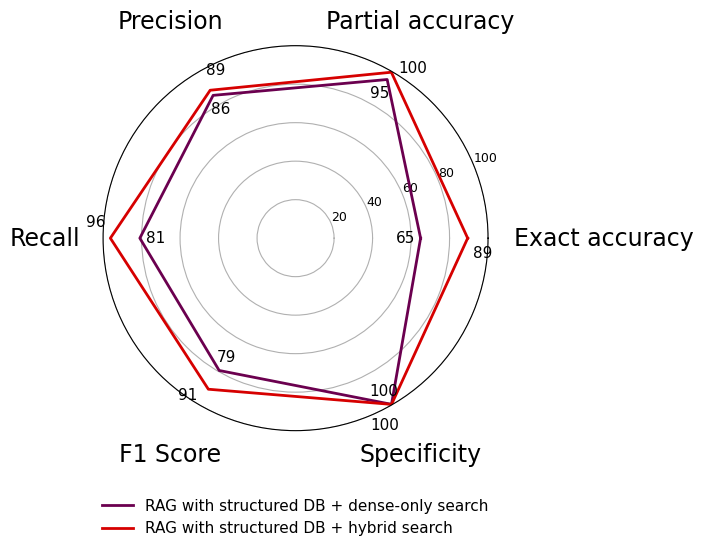

In [ ]:
from math import pi
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

#define metrics to show and their labels
metrics_text = ['Exact accuracy', 'Partial accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity']
eval_metrics_text=dict(zip(_METRICS.values(), metrics_text))


#color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

#specify metrics to show
metrics=eval_metrics_text.keys()
metrics_text=eval_metrics_text.values()

#dense-only search pipeline 
values_dense = list(get_selected_metrics(full_dense_output_eval, metrics=metrics).values())
values_dense += values_dense[:1] 

#hybrid search pipeline
values_hybrid = list(get_selected_metrics(full_hybrid_output_eval, metrics=metrics).values())
values_hybrid += values_hybrid[:1] 

# radar chart setup
angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
angles += angles[:1]

# set up the plot
plt.figure(figsize=(5, 5))
ax = plt.subplot(111, polar=True)

# plot the models
ax.plot(angles, values_dense, color=cols[6], linewidth=2, linestyle='solid', 
        label='RAG with structured DB + dense-only search')
ax.plot(angles, values_hybrid, color=cols[0], linewidth=2, linestyle='solid', 
        label='RAG with structured DB + hybrid search')

# Annotate each metric value
for i in range(len(metrics_text)):
    ax.text(angles[i], values_dense[i] - 8, 
        f"{values_dense[i]:.0f}",
        color='black', fontsize=11, ha='center', va='center')
    ax.text(angles[i] - 0.08, values_hybrid[i] + 8, 
            f"{values_hybrid[i]:.0f}",
            color='black', fontsize=11, ha='center', va='center')

# Labels and ticks
ax.set_ylim(0, 100)
ax.tick_params(axis='y', labelsize=9)
ax.set_xticks([])
for i, metric in enumerate(metrics_text): # Manually set the position of the labels outside the chart
    angle = angles[i]  
    if angle == 0:  
        ax.text(angle, 160, metric, horizontalalignment='center', verticalalignment='center', fontsize=17)       
    else:
        ax.text(angle, 130, metric, horizontalalignment='center', verticalalignment='center', fontsize=17)       

# Create a custom legend
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], color=col, linewidth=2) for col in [cols[6], cols[0]]]
legend = ax.legend(handles, ['RAG with structured DB + dense-only search', 
                             'RAG with structured DB + hybrid search'], 
          title=False, 
          bbox_to_anchor=(0.5, -0.12), ncol=1,
          frameon=False,
          borderaxespad=1,
          loc='upper center',
          fontsize=11
          ) 

legend.get_frame().set_facecolor('white')

# # Save plot
# save = False
# if save == True:
#     plt.savefig(f'./figures/{base_model}/Figure3_ragllmPerformance_radar.jpeg', dpi=600, bbox_inches='tight')

plt.show()

In [317]:
from math import pi
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from typing import Dict, List


def plot_radar_chart(
    eval_results: Dict[str, dict],    # e.g. {"dense": full_dense_output_eval, "hybrid": full_hybrid_output_eval}
    metrics: List[str],               # list of metric keys you want to display
    metric_labels: Dict[str, str],    # mapping from metric key -> pretty label
    title: str = "Model Comparison Radar Plot",
    colors: List[str] = None,
    ylim: int = 100,
    annotate: bool = True,
    save_path: str = None
):
    """
    Plots a radar chart for one or more models.

    eval_results: dict mapping model name -> evaluation dictionary
    metrics: list of metric keys to include (in order)
    metric_labels: dict mapping metric key -> display label
    """
    # set up colors
    if colors is None:
        cols = sns.color_palette(cc.glasbey, n_colors=len(eval_results))
    else:
        cols = colors

    # prepare metric labels + angles
    labels = [metric_labels[m] for m in metrics]
    angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
    angles += angles[:1]  # close the loop

    # start figure
    plt.figure(figsize=(5, 5))
    ax = plt.subplot(111, polar=True)

    # plot each model
    for i, (name, results) in enumerate(eval_results.items()):
        values = [results.get(m, 0)*100 for m in metrics]
        values += values[:1]
        ax.plot(angles, values, color=cols[i], linewidth=2, linestyle="solid", label=name)
        
        # annotate numbers
        if annotate:
            for j, v in enumerate(values[:-1]):
                offset = -8 if i == 0 else 8
                ax.text(
                    angles[j], v + offset,
                    f"{v:.0f}", color="black", fontsize=10,
                    ha="center", va="center"
                )

    # configure axes
    ax.set_ylim(0, ylim)
    ax.set_xticks([])
    ax.tick_params(axis='y', labelsize=9)
    for i, label in enumerate(labels):
        angle = angles[i]
        if angle == 0:  
            ax.text(angle, 160, label, 
                    horizontalalignment='center', verticalalignment='center', 
                    fontsize=17)       
        else:
            ax.text(angle, 130, label, 
                    horizontalalignment='center', 
                    verticalalignment='center', 
                    fontsize=17)

    # legend
    ax.legend(
        loc="upper center", bbox_to_anchor=(0.5, -0.12),
        ncol=2, frameon=False, fontsize=11
    )

    plt.title(title, fontsize=14, pad=20)

    # save or show
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches="tight")
    else:
        plt.show()


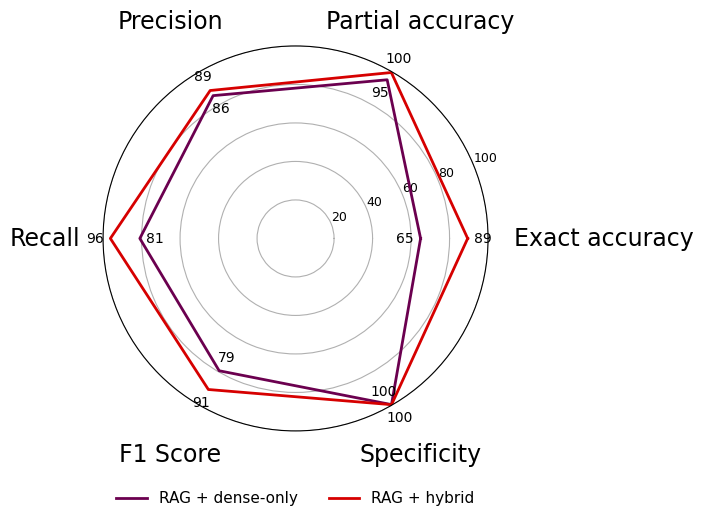

In [321]:
eval_metrics_text = dict(zip(_METRICS.values(),
                             ['Exact accuracy','Partial accuracy','Precision','Recall','F1 Score','Specificity']))

plot_radar_chart(
    eval_results={
        "RAG + dense-only": full_dense_output_eval,
        "RAG + hybrid": full_hybrid_output_eval
    },
    colors=[cols[6],cols[0]],
    metrics=list(_METRICS.values()),
    metric_labels=eval_metrics_text,
    title=None
)

#### Test on real-world validation queries (n=12)

Real-world query and ground-truth therapies

In [5]:
real_world_query_therapy_pair_dict=load_object("data/real_world_db/real_world_query_therapy_pair_dict.pkl")
real_val_query = pd.read_csv(f"data/real_world_db/real_world_validation__v1.csv", index_col=0)

With dense and hybrid search using strategies 0 and 5

In [180]:
num_iter = 5
strategies = ["0", "5"]

# Define evaluation keys
METRICS = {
    "exact": "avg_exact_match_acc",
    "partial": "avg_partial_match_acc",
    "precision": "avg_precision",
    "recall": "avg_recall",
    "f1": "avg_f1",
    "specificity": "avg_specificity"
}

# Initialize result containers
def init_results():
    return {m: {s: [] for s in strategies} for m in METRICS}

results_dense = init_results()
results_hybrid = init_results()

structured_dense_eval = {s: [] for s in strategies}
structured_hybrid_eval = {s: [] for s in strategies}

for s in strategies:
    # Load results
    structured_dense = load_object(
        f"output/RAG_res_gpt4o_default/structured_realworld_val_dense/RAGstra{s}n{num_iter}temp0.0_res_dict.pkl"
    )
    structured_hybrid = load_object(
        f"output/RAG_res_gpt4o_default/structured_realworld_val_hybrid/RAGstra{s}n{num_iter}temp0.0_res_dict.pkl"
    )

    for i in range(num_iter):
        try:
            # 1) calculate metrics
            dense_eval = calc_eval_metrics(
                structured_dense["full output"][i],
                real_val_query["prompt"].tolist(),
                real_world_query_therapy_pair_dict
            )
            hybrid_eval = calc_eval_metrics(
                structured_hybrid["full output"][i],
                real_val_query["prompt"].tolist(),
                real_world_query_therapy_pair_dict
            )
            structured_dense_eval[s].append(dense_eval)
            structured_hybrid_eval[s].append(hybrid_eval)

            # 2) append results dynamically
            for name, key in METRICS.items():
                results_dense[name][s].append(dense_eval[key])
                results_hybrid[name][s].append(hybrid_eval[key])

        except Exception as e:
            continue


In [ ]:
print("Average exact acc:",{key: np.mean(value) for key, value in avg_exact_acc_ls.items()})
print("Average partial acc:",{key: np.mean(value) for key, value in avg_partial_acc_ls.items()})
print("Average precision:",{key: np.mean(value) for key, value in avg_precision_ls.items()})
print("Average recall:",{key: np.mean(value) for key, value in avg_recall_ls.items()})
print("Average f1:",{key: np.mean(value) for key, value in avg_f1_ls.items()})
print("Average specificity:",{key: np.mean(value) for key, value in avg_specificity_ls.items()})

Average exact acc: {'structured_dense': 0.5, 'structured_hybrid': 0.5}
Average partial acc: {'structured_dense': 0.5833333333333334, 'structured_hybrid': 0.5833333333333334}
Average precision: {'structured_dense': 0.9047619047619048, 'structured_hybrid': 0.9047619047619048}
Average recall: {'structured_dense': 0.9285714285714286, 'structured_hybrid': 0.9285714285714286}
Average f1: {'structured_dense': 0.8952380952380953, 'structured_hybrid': 0.8952380952380953}
Average specificity: {'structured_dense': 0.998394863563403, 'structured_hybrid': 0.998394863563403}


#### Test on real-world test queries (n=90)

In [12]:
num_iter = 5
strategies = ["0", "5"]
_DENSE_FILEPATH='output/RAG_res_gpt4o_default/structured_realworld_test_dense'
_HYBRID_FILEPATH='output/RAG_res_gpt4o_default/structured_realworld_test_hybrid'
_QUERY_TEST = pd.read_csv(f"data/real_world_db/real_world_test__v1.csv", index_col=0)
_QUERY_TRUE = load_object("data/real_world_db/real_world_query_therapy_pair_dict.pkl")

With dense and hybrid search using strategies 0 and 5

In [ ]:
query=_QUERY_TEST
true_dict=_QUERY_TRUE

# Initialize result containers
def init_results():
    return {m: {s: [] for s in strategies} for m in _METRICS}

results_dense = init_results()
results_hybrid = init_results()

structured_dense_eval = {s: [] for s in strategies}
structured_hybrid_eval = {s: [] for s in strategies}

for s in strategies:
    structured_dense = load_object(
        os.path.join(_DENSE_FILEPATH, f"RAGstra{s}n{num_iter}temp0.0_res_dict.pkl")
    )
    structured_hybrid = load_object(
        os.path.join(_HYBRID_FILEPATH, f"RAGstra{s}n{num_iter}temp0.0_res_dict.pkl")
    )

    for i in range(num_iter):
        try:
            # 1) calculate metrics
            dense_eval = calc_eval_metrics(
                structured_dense["full output"][i],
                query["prompt"].tolist(),
                true_dict
            )
            hybrid_eval = calc_eval_metrics(
                structured_hybrid["full output"][i],
                query["prompt"].tolist(),
                true_dict
            )
            structured_dense_eval[s].append(dense_eval)
            structured_hybrid_eval[s].append(hybrid_eval)

            # 2) append results dynamically
            for name, key in _METRICS.items():
                results_dense[name][s].append(dense_eval[key])
                results_hybrid[name][s].append(hybrid_eval[key])

        except Exception as e:
            continue
        

Average performance values across five runs

In [10]:
from utils.evaluation import get_avg_eval_runs, plot_radar_chart

In [ ]:
structured_dense_eval_avg=get_avg_eval_runs(structured_dense_eval['5'])
structured_hybrid_eval_avg=get_avg_eval_runs(structured_hybrid_eval['5'])

In [64]:
structured_dense_eval_avg

{'avg_exact_match_acc': 50.22222222222222,
 'avg_partial_match_acc': 67.77777777777779,
 'avg_precision': 57.25490196078431,
 'avg_recall': 48.36309523809523,
 'avg_f1': 49.47295841413489,
 'avg_specificity': 99.84171888863773}

In [65]:
structured_hybrid_eval_avg

{'avg_exact_match_acc': 55.33333333333333,
 'avg_partial_match_acc': 73.1111111111111,
 'avg_precision': 60.88235294117648,
 'avg_recall': 52.34418767507002,
 'avg_f1': 53.67627307333189,
 'avg_specificity': 99.85174364283677}

In [ ]:
eval_metrics_text = dict(zip(_METRICS.values(),
                             ['Exact accuracy','Partial accuracy','Precision','Recall','F1 Score','Specificity']))

cols=sns.color_palette(cc.glasbey, n_colors=40)

plot_radar_chart(
    eval_results={
        "RAG + dense-only": structured_dense_eval['5'][0],
        "RAG + hybrid": structured_hybrid_eval['5'][0]
    },
    colors=[cols[6],cols[0]],
    metrics=list(_METRICS.values()),
    metric_labels=eval_metrics_text,
    title=None
)

Subset questions that are within the scope of our study (n=83)

In [33]:
_QUERY_RAW=pd.read_csv(f"data/real_world_db/updated_real_world_queries_answers__v1.csv")
_QUERY_RAW=_QUERY_RAW.dropna(subset='Questions').reset_index(drop=True)

query_in_scope=_QUERY_RAW[
    (_QUERY_RAW['Asking_genomic_biomarker_linked_therapy']==True) &
    (_QUERY_RAW['Asking_therapy']==True)
    ].index.tolist()

print(len(query_in_scope))
print(len(set(query_in_scope).intersection(set(_QUERY_TEST.index))))

95
83


In [34]:
_QUERY_TESTv2=_QUERY_TEST.reset_index()
query_in_scope_idx=_QUERY_TESTv2[_QUERY_TESTv2['index'].isin(query_in_scope)].index

In [35]:
subset_dense_results = {f"{_METRICS['exact']}":[],f"{_METRICS['partial']}":[]}
subset_hybrid_results = {f"{_METRICS['exact']}":[],f"{_METRICS['partial']}":[]}
for i in range(5):
    subset_dense_results[_METRICS['exact']].append(np.array([e for i, e in enumerate(structured_dense_eval['5'][i]['exact_match_acc']) if i in query_in_scope_idx]).mean())
    subset_dense_results[_METRICS['partial']].append(np.array([e for i, e in enumerate(structured_dense_eval['5'][i]['partial_match_acc']) if i in query_in_scope_idx]).mean())
    
    subset_hybrid_results[_METRICS['exact']].append(np.array([e for i, e in enumerate(structured_hybrid_eval['5'][i]['exact_match_acc']) if i in query_in_scope_idx]).mean())
    subset_hybrid_results[_METRICS['partial']].append(np.array([e for i, e in enumerate(structured_hybrid_eval['5'][i]['partial_match_acc']) if i in query_in_scope_idx]).mean())

In [36]:
{k: np.array(v).mean() for k, v in subset_dense_results.items()}

{'avg_exact_match_acc': 0.5325301204819277,
 'avg_partial_match_acc': 0.7228915662650603}

In [37]:
{k: np.array(v).mean() for k, v in subset_hybrid_results.items()}

{'avg_exact_match_acc': 0.5879518072289157,
 'avg_partial_match_acc': 0.780722891566265}

In [ ]:
plot_radar_chart(
    eval_results={
        "RAG + dense-only (all)": structured_dense_eval['5'][0],
        "RAG + hybrid" (all): structured_hybrid_eval['5'][0],
        "RAG + hybrid (within scope)":  
    },
    colors=[cols[6],cols[0]],
    metrics=list(_METRICS.values()),
    metric_labels=eval_metrics_text,
    title=None
)

##### Inspect failed ones in both dense and hybrid serach

In [ ]:
dense_eval_single_run=structured_dense_eval['5'][0]
hybrid_eval_single_run=structured_hybrid_eval['5'][0]

for i, e in enumerate(dense_eval_single_run['partial_match_acc']):
    if i in query_in_scope_idx and e == False:
        print(f"=============={i}============")
        print(dense_eval_single_run['pred_drugs_generic_set_ls'])
        print(dense_eval_single_run['true_drugs_generic_set_ls'])